In [60]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs
from epi.example_eps import V1_dr_eps, V1_all_dr_eps

from epi.example_eps import euler_sim, euler_sim_traj, load_W
import tensorflow as tf

npzfile = np.load('SV_mode.npz')
z_mode_SV = npzfile['z_mode1']

neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
figdir = "./"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
W_mean = load_W()
W_mean_vec = np.reshape(W_mean, (16,))
print(W_mean_vec)
delta = 0.001

lb_W = np.array([max(0., val) if (i % 4)==0 else val for i, val in enumerate(W_mean_vec-delta)])
ub_W = np.array([min(0., val) if (i % 4)!=0 else val for i, val in enumerate(W_mean_vec+delta)])

print(lb_W)
print(ub_W)


[ 4.60800e-02 -1.57824e-02 -7.88640e-03 -1.46160e-03  4.70840e-01
 -2.45344e-02 -2.57100e-02 -2.16000e-04  1.25216e-01 -1.00800e-03
 -7.38000e-04 -1.20000e-02  1.10040e-01 -7.21600e-03 -2.40240e-02
 -6.21600e-04]
[ 0.04508    -0.0167824  -0.0088864  -0.0024616   0.46984002 -0.0255344
 -0.02671    -0.001216    0.12421601 -0.002008   -0.001738   -0.013
  0.10904    -0.008216   -0.025024   -0.0016216 ]
[ 4.70799990e-02 -1.47823989e-02 -6.88640028e-03 -4.61599906e-04
  4.71839994e-01 -2.35344004e-02 -2.47099996e-02  0.00000000e+00
  1.26216009e-01 -7.99994450e-06  0.00000000e+00 -1.09999999e-02
  1.11040004e-01 -6.21599983e-03 -2.30240002e-02  0.00000000e+00]


In [62]:
W = Parameter("W", 16, lb=lb_W, ub=ub_W)
parameters = [W]

sigma_eps = 0.0

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [63]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)

In [12]:
X_INIT = tf.constant(np.random.normal(1.0, 0.01, (1, 4, 1)).astype(np.float32))

H = z_mode_SV[:,:4]
DH = z_mode_SV[:,4:]

def V1_sim_W(W, h, dh, sigma_eps=0.1):
    h = h[:, :, None]
    dh = tf.concat((dh, tf.zeros_like(dh, dtype=tf.float32)), axis=1)[:, :, None]
    
    W = tf.reshape(W, (-1, 4, 4))

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02
    
    M = max(W.shape[0], h.shape[0])

    _x_shape = tf.ones((M, 4, 1), dtype=tf.float32)
    x_init = _x_shape*X_INIT

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + dh + noise) ** n)) / tau

    r_t = euler_sim_traj(f, x_init, dt, T)
    return r_t


def ISN_coeff(W):
    h = H[:,:,None]
    dh = DH[:,:,None]
    
    W = tf.reshape(W, (-1, 4, 4))

    n = 2.
    dt = 0.005
    T = 100
    tau = 0.02

    _x_shape = tf.ones((W.shape[0], 4, 1), dtype=tf.float32)
    x_init = _x_shape*X_INIT

    def f(y):
        omega = tf.random.normal(y.shape, 0., 1.)
        noise = sigma_eps*omega
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h + noise) ** n)) / tau
    

    r_ss = euler_sim(f, x_init, dt, T)
    h_E = h[0,0,0]
    u_E = tf.tensordot(W[:,0,:], r_ss, [1,1])[0,0] + h_E
    u_E = tf.nn.relu(u_E)
    isn_coeff = 1.-2*(u_E)*W[:,0,0]
    
    def f_noeps(y):
        return (-y + (tf.nn.relu(tf.matmul(W, y) + h) ** n)) / tau
    
    r_ss_noeps = euler_sim(f_noeps, r_ss[:,:,None], dt, 50)
    f_norm = tf.norm(r_ss_noeps, axis=1)
    
    return tf.stack((isn_coeff, f_norm), axis=1)


    
model.set_eps(ISN_coeff)

[2.001505  9.086761  2.4126804 4.161158 ]


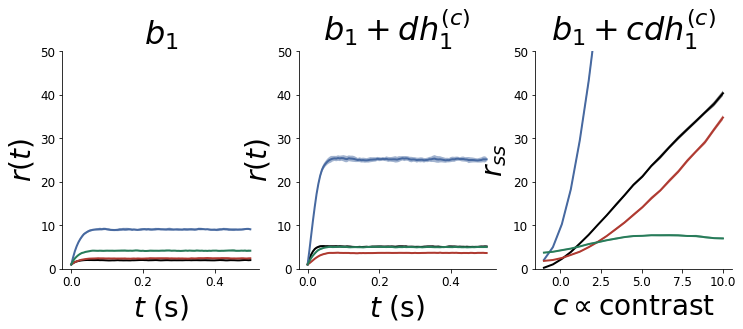

In [20]:
def plot_sims(z, sigma_eps=0.05, gamma_lims=(-1,2), M=200, subscript=None, fontsize=14, ylim=None):
    h = H
    dh = DH
    
    dW = tf.reshape(z, (-1, 4, 4))
    W = W_mean + dW

    _h = np.tile(h, [M, 1])
    _dh = np.tile(dh, [M, 1])
    r_ts = []
    gammas = np.concatenate((np.array([0,1,]), np.linspace(gamma_lims[0], gamma_lims[1], 21)))
    for gamma in gammas:
        r_ts.append(V1_sim_W(dW, _h, gamma*_dh))
    r_ts = np.array(r_ts)
    mean_r_ts = np.mean(r_ts, axis=1)
    std_r_ts = np.std(r_ts, axis=1)

    t = 0.005*np.arange(101)
    fig, axs = plt.subplots(1,3, figsize=(12,4))

    for i in range(4):
        axs[0].plot(t, mean_r_ts[0,i,:], c=colors[i])
        axs[0].fill_between(t, 
                            mean_r_ts[0,i,:]-std_r_ts[0,i,:],
                            mean_r_ts[0,i,:]+std_r_ts[0,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[1].plot(t, mean_r_ts[1,i,:], c=colors[i])
        axs[1].fill_between(t, 
                            mean_r_ts[1,i,:]-std_r_ts[1,i,:],
                            mean_r_ts[1,i,:]+std_r_ts[1,i,:],
                            facecolor=colors[i], alpha=0.5)

        axs[2].plot(gammas[2:], mean_r_ts[2:,i,-1], c=colors[i])
        axs[2].fill_between(gammas[2:], 
                            mean_r_ts[2:,i,-1]-std_r_ts[2:,i,-1],
                            mean_r_ts[2:,i,-1]+std_r_ts[2:,i,-1],
                            facecolor=colors[i], alpha=0.5)
    print(mean_r_ts[0,:,-1])
        
    axs[0].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[0].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[0].set_title(r'$b_%d$' % subscript, fontsize=fontsize+4)
    else:
        axs[0].set_title(r'$b$', fontsize=fontsize+4)
    
    axs[1].set_xlabel(r'$t$ (s)', fontsize=fontsize)
    axs[1].set_ylabel(r'$r(t)$', fontsize=fontsize)
    if subscript is not None:
        axs[1].set_title(r'$b_%d + dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[1].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
    
    axs[2].set_xlabel(r"$c \propto $contrast", fontsize=fontsize)
    axs[2].set_ylabel(r'$r_{ss}$', fontsize=fontsize)
    if subscript is not None:
        axs[2].set_title(r'$b_%d + c dh^{(c)}_%d$' % (subscript, subscript), fontsize=fontsize+4)
    else:
        axs[2].set_title(r'$b + dh^{(c)}$', fontsize=fontsize+4)
        
    if ylim is not None:
        for i in range(3):
            axs[i].set_ylim(ylim)
    return gammas[2:], mean_r_ts[2:], std_r_ts[2:]

_,_,_ = plot_sims(W_mean_vec, sigma_eps=sigma_eps, ylim=[0,50],
                  gamma_lims=(-1,10), M=20, subscript=1, fontsize=28)

In [21]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])

In [56]:
M = 1000
num_keep = 200

mean = [-.25]
std = [0.125]

def accept_inds(T_x, mean ,std):
    accept = np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])
    accept = np.logical_and(accept, T_x[:,1] < 100.)
    return accept

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D), dtype=np.float32)
    for j in range(D):
        _z[:,j] = 25*np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)
    

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]



[0 1 2 3]
[4 5 6 7]
[ 8  9 10 11]
[12 13 14 15]


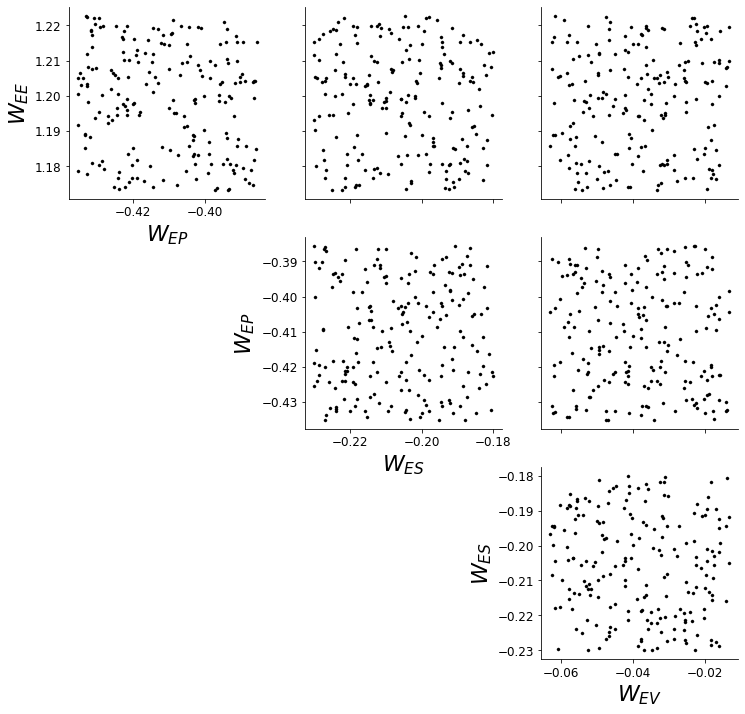

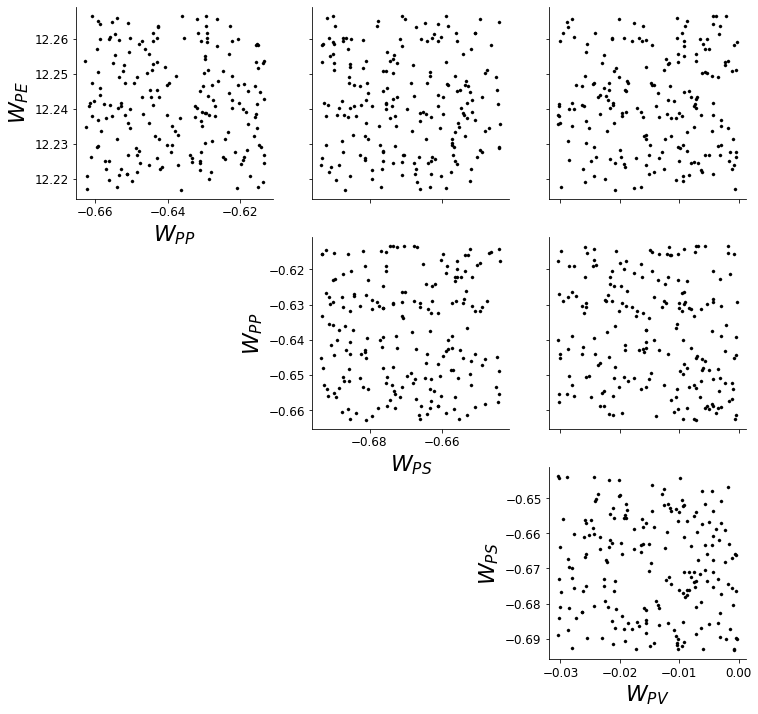

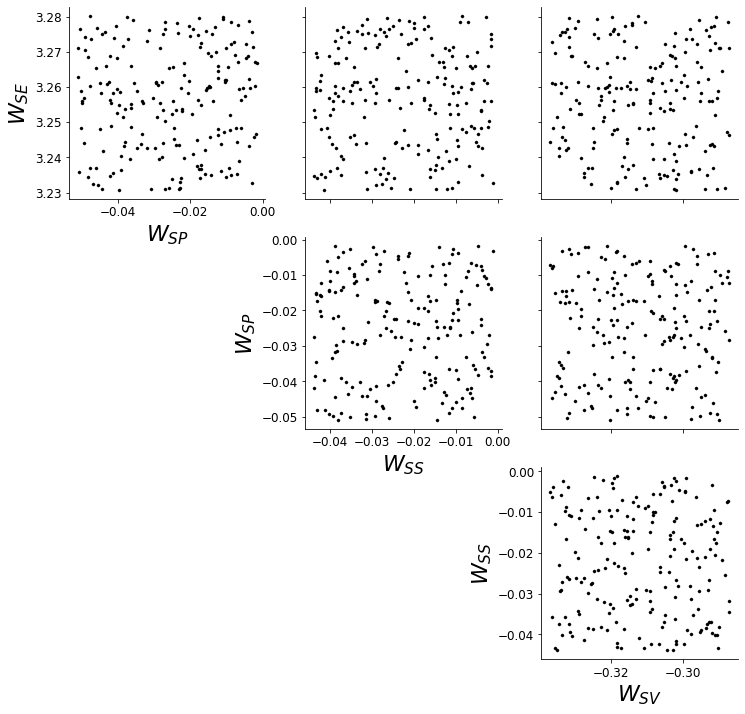

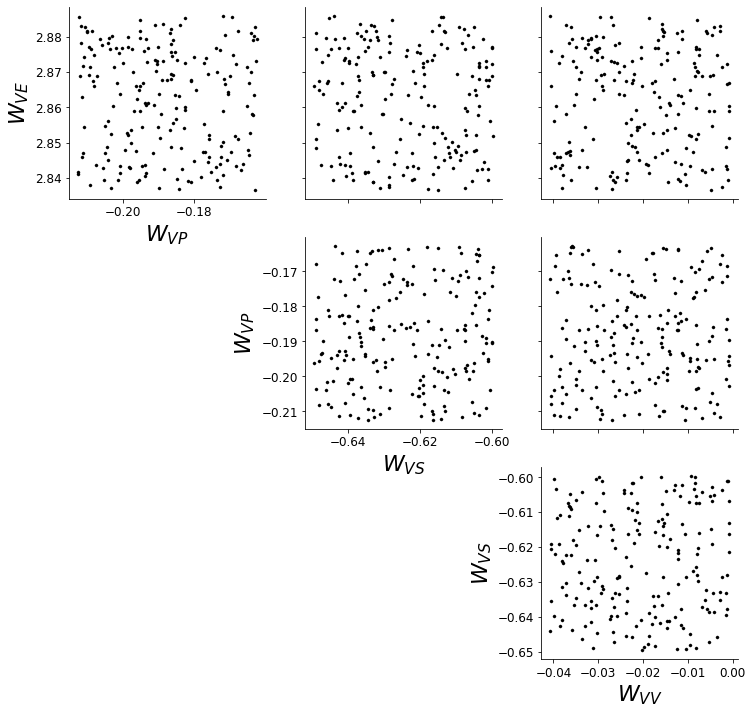

In [57]:

W = z + W_mean_vec[None,:]
num_plot = 500
fontsize = 14
z_labels = [r'$W_{EE}$', r'$W_{EP}$', r'$W_{ES}$', r'$W_{EV}$',
            r'$W_{PE}$', r'$W_{PP}$', r'$W_{PS}$', r'$W_{PV}$',
            r'$W_{SE}$', r'$W_{SP}$', r'$W_{SS}$', r'$W_{SV}$',
            r'$W_{VE}$', r'$W_{VP}$', r'$W_{VS}$', r'$W_{VV}$']

for i in range(4):
    _range = np.arange(i*4, (i+1)*4)
    print(_range)
    fig = pairplot(W[:num_plot], _range, [z_labels[j] for j in _range],
                   fontsize=22, outlier_stds=2)
                   #lb=lb+W_mean_vec, ub=ub+W_mean_vec)

-0.22421527
[0.18764347 1.8366283  3.2778091  0.07633372]


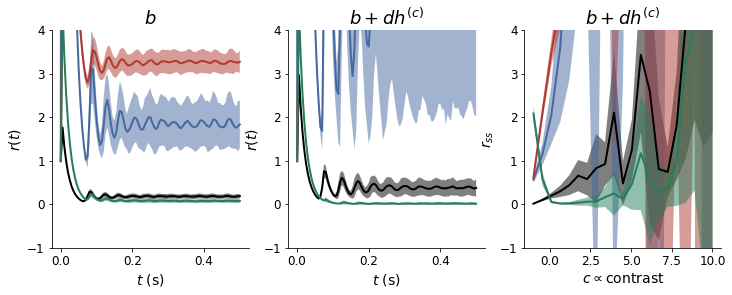

-0.18702507
[0.17514127 1.8888713  3.08346    0.09863599]


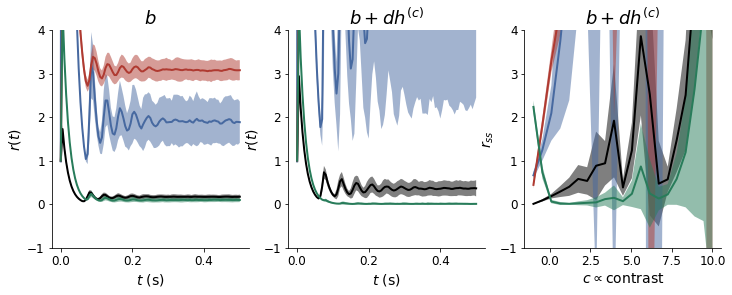

-0.21340287
[0.16675569 1.8535095  3.0202284  0.08540519]


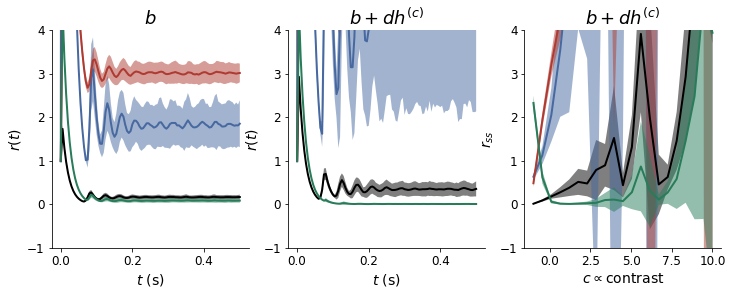

-0.18410969
[0.16250193 1.6725     3.4273438  0.03859994]


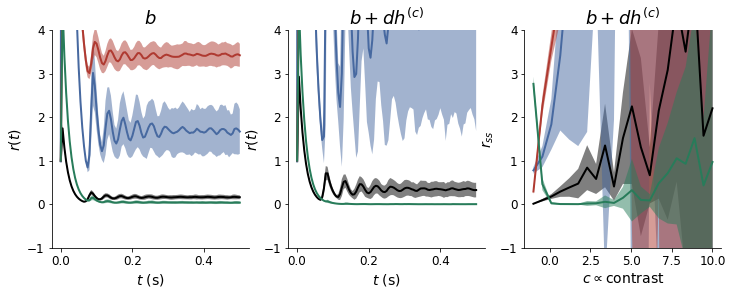

In [59]:
for i in range(4):
    print(_T_x[i,0])
    _,_,_ = plot_sims(z[i], M=200, gamma_lims=(-1., 10.), ylim=(-1,4))
    plt.show()